# Lab 1 - K-Nearest Neighbours

This lab is about the implementation and analysis of the KNN algorithm for classification problems

In [ ]:
### If you use colab uncomment these line and upload Material.zip

#from google.colab import files

#files.upload()
#!unzip Material.zip

In [ ]:
# Packages used
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.interpolate import griddata
import os
import pickle
np.random.seed(100)

### Data generation for binary classification

We start generating a training set for binary classification problems. Consider the following function, that generates random 2D points on the plane and assigns them a binary label according to their position w.r.t. a linear separator.

The function `linearBinaryClass`, given a sample size `n`, lower and upper bounds `low_D, high_D` for the domain of the samples and the linear function parameters `m, q`, generates a binary classification dataset i.e. it returns `X` and `Y`.

The signature of the function is the following:

`X, Y = linearBinaryClass(n, low_D, high_D, m, q)`

where
- **n** is the number of samples to be generated
- **low_D** and **high_D** are, respectively, the lower and upper bounds for the domain of the samples i.e.
    $$
    X_{i,j} \sim \mathcal{U}(\text{low\_D}, \text{high\_D})
    $$
- **m, q** are the linear function parameters
- **X**, **Y**: 2-dimensional samples (X) associated with 1-dimensional binary labels (Y)


In [ ]:
def linearBinaryClass(n, low_D, high_D, m, q):
    X = (np.random.rand(n, 2) * (high_D - low_D)) + low_D
    Y = np.sign((X[:,1] - (m * X[:,0]) + q))
    Y[Y==0] = 1
    return X,Y

### Computing the distance between input points

In order to build the KNN estimator we need to resort to a distance function.

Consider a function that computes the euclidean distance between two points...

In [ ]:
def euclidDistance(P1,P2):
    return np.linalg.norm(P1-P2,2)

... and then a function that computes all the distance between two set of points stored in two matrices.

In [ ]:
def allDistances(X1, X2):
    D = np.zeros((X1.shape[0], X2.shape[0]))
    for idx1 in range(len(X1)):
        for idx2 in range(len(X2)):
            D[idx1,idx2] = euclidDistance(X1[idx1,:],X2[idx2,:])
    return D

The usage is the following:

**D = allDistances(X1,X2)**

where
- **X1** is a matrix of size $n_1 \times D$, where each row is a D-dimensional point
- **X2** is a matrix of size $n_2 \times D$, where each row is a D-dimensional point
- **D** is a matrix of size $n_1 \times n_2$, where each element `D[i,j]` is the distance between points (`X1[i, :]`, `X2[j, :]`)

### Adding noise to the samples

To make the task harder, we may want to perturb the labels with some noise.

In our case, we have binary labels and a common way of adding noise is to flip the value of a small percentage of the labels. For example, if a label was $+1$ it will become $-1$.

The `flipLabels` function takes two arguments:
 - `Y`, the numpy array of original labels
 - `P`, an integer between 1 and 100 specifying the percentage of labels which will be flipped
and returns an array of the same shape as `Y`, which contains the noisy labels.


In [ ]:
def flipLabels(Y, P):
    if P < 1 or P > 100:
        raise Exception('P should be between 1 and 100')
        
    indices_to_flip = np.random.choice(range(len(Y)), int(len(Y) * (P / 100)), replace=False)
    Y_noisy = Y.copy()
    Y_noisy[indices_to_flip] *= -1
    
    return Y_noisy


### Assignment 1: The KNN classifier

We are now ready to use the KNN algorithm to estimate the classification function. 

Implement the `kNNClassify` function which train a KNN classifier on given training set and returns predictions on a given test set. 

The signature of the function is the following:

`Ypred = kNNClassify(Xtr, Ytr, k, Xte)`

where
- **Xtr** is a matrix of size [ntr, D], where each row is a D-dimensional point (INPUT IN THE **TRAINING SET**)
- **Ytr** is an array of size [ntr], where each element is a binary label (OUTPUT IN THE **TRAINING SET**)
- **k** is the number of neighbours to be considered
- **Xte** is a matrix of size [nte, D], where each row is a D-dimensional point (INPUT IN THE **TEST SET**)
- **Ypred** is an array of size [nte], where each element is a binary label (ESTIMATED OUTPUT FOR THE **TEST SET**)

where [ntr] and [nte] are respectively the number of points in the training set and the number of points in the test set

In [ ]:
def kNNClassify(Xtr, Ytr, k, Xte):

    n_train = Xtr.shape[0] # number of the training inputs
    n_test = Xte.shape[0] # number of the test inputs

    if any(np.abs(Ytr) != 1):
        raise Exception("The values of Ytr should be +1 or -1.")

    if k > n_train:
        print("k is greater than the number of points, setting k=n_train")
        k = n_train

    Ypred = np.zeros(n_test)

    # Compute all the distances from TEST input and TRAINING input
    dist = allDistances(Xte, Xtr)
    
    
    # For each test point, the predicted class will be 

    # the sign of the average label of the k nearest points

    for idx in range(n_test):
        # Hint 1: take all the distances for the current test point
        distances = dist[idx,:]
        # Hint 2: Sort the indices of the distances
        sorted_indices = np.argsort(distances)
        # Hint 3: Get the indices of the k lowest of distances
        k_indices = sorted_indices[:k]
        # Hint 4: Compute the mean of the output values of the corresponding training points and taking the sign of it.
        k_labels = Ytr[k_indices]
        Ypred[idx] = np.sign(np.mean(k_labels))
    return Ypred


### Visualizing the separating function

The visualization of the separating function on the training set, i.e. the function estimated by classification algorithm for discriminating between classes, is of benefit for appreciating the behavior of the binary classifier. To visualize the separating function use the following:

**_separatingFkNN(Xtr, Ytr, k)_**

where
- **Xtr** is a matrix of size [ntr, D], where each row is a D-dimensional point (INPUT IN THE **TRAINING SET**)
- **Ytr** is an array of size [ntr], where each element is a binary label (OUTPUT IN THE **TRAINING SET**)
- **k** is the number of neighbours to be considered

In [ ]:
def separatingFkNN(Xtr, Ytr, k, Xte):
    Ypred = kNNClassify(Xtr=Xtr, Ytr=Ytr, k=k, Xte=Xte)

    x = Xtr[:, 0]
    y = Xtr[:, 1]
    xi = np.linspace(x.min(), x.max(), 200)
    yi = np.linspace(y.min(), y.max(), 200)
    zi = griddata((x, y), Ypred, (xi[None, :], yi[:, None]), method='linear')

    plt.subplots()
    CS = plt.contour(xi, yi, zi, 15, linewidths=2, colors='k', levels=[0])
    # plot data points.
    plt.scatter(x, y, c=Ytr, marker='o', s=50, zorder=10, alpha=0.8)
    plt.xlim(x.min(), x.max())
    plt.ylim(x.min(), x.max())
    msg = 'Separating function, k='+str(k);
    plt.title(msg)

### Evaluating the goodness of a classifier

To evaluate how good is the classification function estimated by the KNN, we compare the predicted binary labels and expected (true) ones, with the following function:

`err = calcError(Ypred, Ytrue)`

where
- **Ypred** is an array of size $n$, where each element is a binary label predicted by the classifier
- **Ytrue** is an array of size $n$, where each element is the true binary label
- **err** is the fraction of wrongly classified elements wrt the total number


In [ ]:
def calcError(Ypred, Ytrue):
    return (np.count_nonzero(Ypred != Ytrue)) / len(Ytrue)

### Assignment 2: Noise-free case

In this assignment, we start to play with the NN classifier. In specific:

- 1.Generate a training set WITHOUT NOISE
- 2.Visualize the separating curve for the **NN** classifier 
- 3.Generate a test set with the same amount of noise as the training set.
- 4.Compute the error on the TRAINING and then on the TEST SET



In [ ]:
### Generate training and test sets, build and evaluate the KNN classifier
n = 200
D = 2

m = 0.9
q = 0.0

low_D = -10
high_D = 10

k = 1

#TODO: Generate a training set WITHOUT NOISE
Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)

#TODO: Visualize the separating curve for the NN classifier on the TRAINING SET
separatingFkNN(Xtr, Ytr, k, Xtr)
#TODO: Generate a test set WITHOUT NOISE
Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q)

#TODO: Evaluate the NN classifier on the TEST SET
Ypred = kNNClassify(Xtr, Ytr, k, Xte)

#TODO: Compute the error on the TEST SET
err = calcError(Ypred, Yte)

print("With K=%d the error on the test set is " % (k), err)

# How the classifier perform on the TRAINING SET instead?
Ypredtr = kNNClassify(Xtr, Ytr, k, Xtr)
errtr = calcError(Ypredtr, Ytr)
print("With K=%d the error on the training set is " % (k), errtr)

### Assignment 3: adding noise

Keeping the parameters of the function and the number of points as in the previous assignment:

- 1.Generate a training set WITH NOISE (for instance with 10% of flipped labels)
- 2.Visualize the separating curve for the **NN** classifier 
- 3.Generate a test set with the same amount of noise as the training set.
- 4.Evaluate the NN classifier on the TRAINING and on the TEST SET
- 5.Compute the obtained error on the TRAINING and on the TEST SET

- Repeat the steps from 1 to 5 with the **KNN** algorithm, setting for instance K=5

OBSERVE WHAT CHANGES...

In [ ]:
# ... your code goes here... #
### Generate training and test sets, build and evaluate the KNN classifier
n = 200
D = 2

m = 0.9
q = 0.0

low_D = -10
high_D = 10

k = 5

#TODO: Generate a training set  NOISE = 10%
Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)
Ytr= flipLabels(Ytr, 10)
#TODO: Visualize the separating curve for the NN classifier on the TRAINING SET
separatingFkNN(Xtr, Ytr, k, Xtr)
#TODO: Generate a test set WITHOUT NOISE
Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q)
Yte= flipLabels(Yte, 10)
#TODO: Evaluate the NN classifier on the TEST SET
Ypred = kNNClassify(Xtr, Ytr, k, Xte)

#TODO: Compute the error on the TEST SET
err = calcError(Ypred, Yte)

print("With K=%d the error on the test set is " % (k), err)

# How the classifier perform on the TRAINING SET instead?
Ypredtr = kNNClassify(Xtr, Ytr, k, Xtr)
errtr = calcError(Ypredtr, Ytr)
print("With K=%d the error on the training set is " % (k), errtr)

Describe here what changes: 

### Assignment 4

Analyse the performance of the **KNN** with plots, considering in particular the following:



- **SCENARIO 1**: Fix the number n of points to 200, fix the amount of noise to 10%, and plot the performance of the KNN classifier on TRAINING and TEST SETS as you increase the value of K

- **SCENARIO 2**: Fix the number n of points to 200, fix the value of K to a reasonable number of neighbours, and plot the performance of the KNN classifier on TRAINING and TEST SETS as you increase the amount of noise

- **SCENARIO 3**: Fix noise and K to two reasonable values, fix the number of TEST samples to 300, and plot the performance of the KNN classifier on TRAINING and TEST SETS as you increase the number of TRAINING samples (e.g. from 30 to 300 with steps 30)

For each scenario, describe what happen

- **SCENARIO 1**: Fix the number n of points to 200, fix the amount of noise to 10%, and plot the performance of the KNN classifier on TRAINING and TEST SETS as you increase the value of K

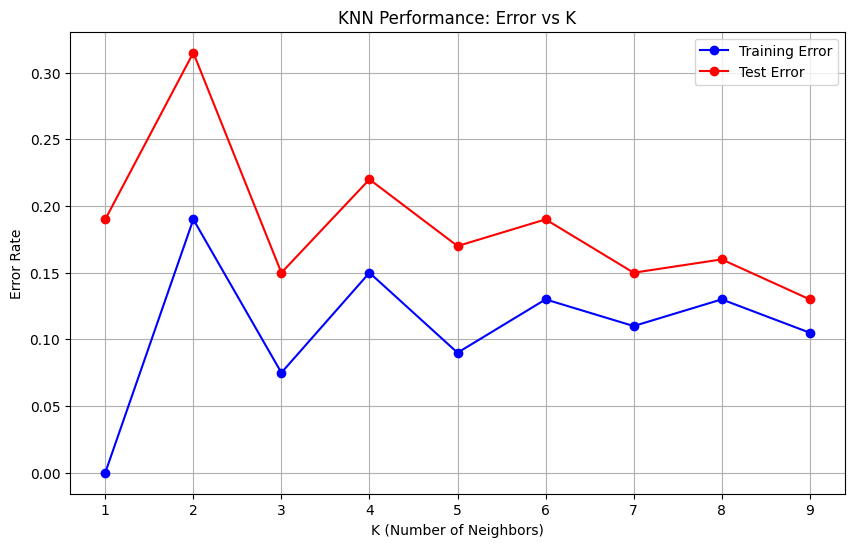

In [24]:
# Set up the parameters
n = 200
D = 2
m = 0.9
q = 0.0
low_D = -10
high_D = 10
k_values = range(1,10)  # K values from 1 to 15

# Initialize lists to store the errors
train_errors = []
test_errors = []

# Generate a training set with 10% noise
Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)
Ytr = flipLabels(Ytr, 10)

# Generate a test set with 10% noise
Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q)
Yte = flipLabels(Yte, 10)

# Evaluate the KNN classifier for different values of K
for k in k_values:
    # Compute predictions on training set
    Ypred_tr = kNNClassify(Xtr, Ytr, k, Xtr)
    err_tr = calcError(Ypred_tr, Ytr)  # Error on the training set
    train_errors.append(err_tr)
    
    # Compute predictions on test set
    Ypred_te = kNNClassify(Xtr, Ytr, k, Xte)
    err_te = calcError(Ypred_te, Yte)  # Error on the test set
    test_errors.append(err_te)

# Plot the errors for both training and test sets
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_errors, label="Training Error", marker='o', linestyle='-', color='blue')
plt.plot(k_values, test_errors, label="Test Error", marker='o', linestyle='-', color='red')
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Error Rate')
plt.title('KNN Performance: Error vs K')
plt.legend()
plt.grid(True)
plt.show()

- **SCENARIO 2**: Fix the number n of points to 200, fix the value of K to a reasonable number of neighbours, and plot the performance of the KNN classifier on TRAINING and TEST SETS as you increase the amount of noise

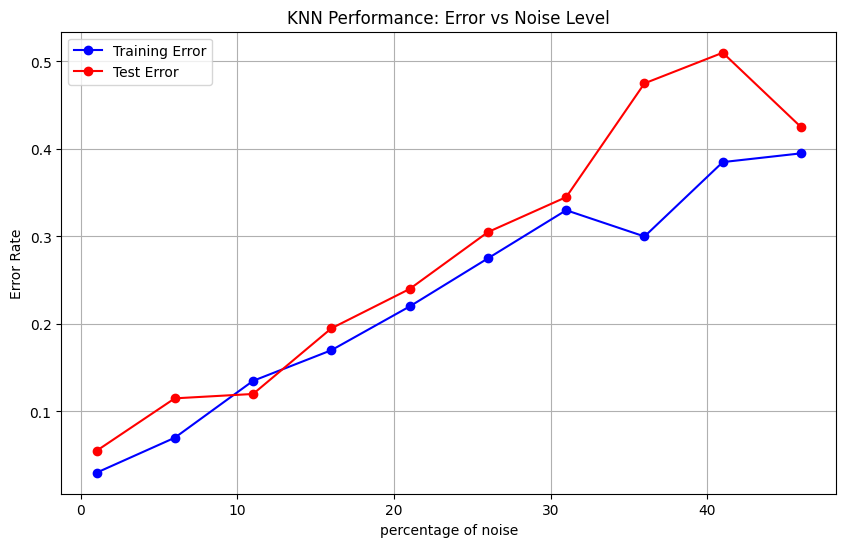

In [23]:
# ... your code for SCENARIO# Set up the parameters
n = 200
D = 2
m = 0.9
q = 0.0
low_D = -10
high_D = 10
k_values = 5  

# Initialize lists to store the errors
train_errors = []
test_errors = []

noise_levels = range(1, 51, 5)

# print(range(0, 51, 5))

for noise in noise_levels:

    # Generate a training set with 10% noise
    Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)
    Ytr = flipLabels(Ytr, noise)

    # Generate a test set with 10% noise
    Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q)
    Yte = flipLabels(Yte, noise)

    # Compute predictions on training set
    Ypred_tr = kNNClassify(Xtr, Ytr, k, Xtr)
    err_tr = calcError(Ypred_tr, Ytr)  # Error on the training set
    train_errors.append(err_tr)
        
    # Compute predictions on test set
    Ypred_te = kNNClassify(Xtr, Ytr, k, Xte)
    err_te = calcError(Ypred_te, Yte)  # Error on the test set
    test_errors.append(err_te)

# Plot the errors for both training and test sets
plt.figure(figsize=(10, 6))
plt.plot(noise_levels, train_errors, label="Training Error", marker='o', linestyle='-', color='blue')
plt.plot(noise_levels, test_errors, label="Test Error", marker='o', linestyle='-', color='red')
plt.xlabel('percentage of noise')
plt.ylabel('Error Rate')
plt.title('KNN Performance: Error vs Noise Level')
plt.legend()
plt.grid(True)
plt.show() 

- **SCENARIO 3**: Fix noise and K to two reasonable values, fix the number of TEST samples to 300, and plot the performance of the KNN classifier on TRAINING and TEST SETS as you increase the number of TRAINING samples (e.g. from 30 to 300 with steps 30)

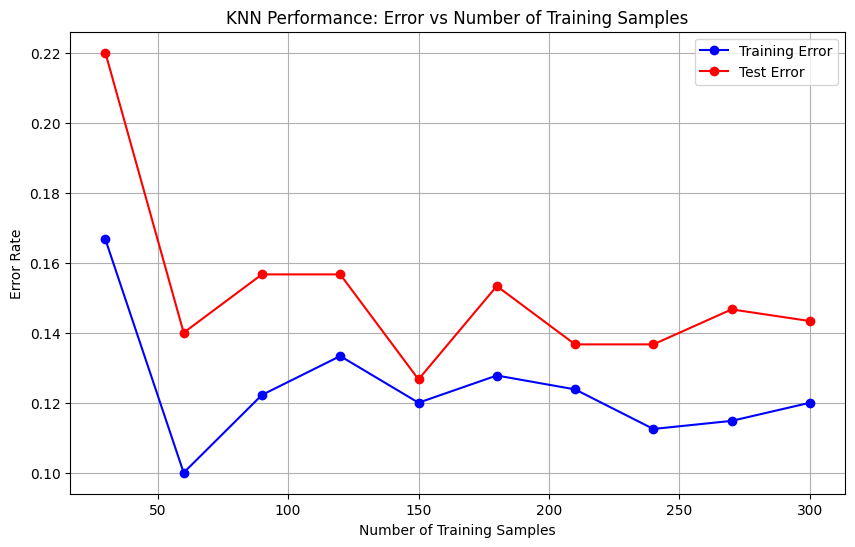

In [25]:
# ... your code for SCENARIO 3 goes here..


D = 2
m = 0.9
q = 0.0
low_D = -10
high_D = 10

# Set parameters
n_test = 300  # Fixed number of test samples
k = 5         # Fixed number of neighbors for KNN
noise_level = 10  # Noise level (e.g., 10%)

train_sizes = range(30, 301, 30)  # Vary the number of training samples (30 to 300, step 30)

# Initialize lists to store errors for both training and test sets
train_errors = []
test_errors = []

# For each number of training samples
for n_train in train_sizes:
    # Generate training set with noise
    Xtr, Ytr = linearBinaryClass(n_train, low_D, high_D, m, q)
    Ytr = flipLabels(Ytr, noise_level)  # Add noise to labels

    # Generate test set with noise
    Xte, Yte = linearBinaryClass(n_test, low_D, high_D, m, q)
    Yte = flipLabels(Yte, noise_level)  # Add noise to labels
    
    # Compute predictions on the training set
    Ypred_tr = kNNClassify(Xtr, Ytr, k, Xtr)
    err_tr = calcError(Ypred_tr, Ytr)  # Error on the training set
    train_errors.append(err_tr)
    
    # Compute predictions on the test set
    Ypred_te = kNNClassify(Xtr, Ytr, k, Xte)
    err_te = calcError(Ypred_te, Yte)  # Error on the test set
    test_errors.append(err_te)

# Plot the errors for both training and test sets as the number of training samples increases
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_errors, label="Training Error", marker='o', linestyle='-', color='blue')
plt.plot(train_sizes, test_errors, label="Test Error", marker='o', linestyle='-', color='red')
plt.xlabel('Number of Training Samples')
plt.ylabel('Error Rate')
plt.title('KNN Performance: Error vs Number of Training Samples')
plt.legend()
plt.grid(True)
plt.show()


Insert here your observations:
- **SCENARIO 1**:
- **SCENARIO 2**:
- **SCENARIO 3**:


Training Error: As K increases, the training error typically decreases, because KNN with a larger K will smooth out the predictions by considering more neighbors, leading to a more general fit to the training data.
Test Error:
For small K (e.g., K = 1), the model might be too sensitive to noise and might overfit, which would cause higher test errors.
As K increases, the test error will generally decrease (due to smoother predictions and better generalization), but after a certain point, the test error might increase again (for very large K) because the model becomes too simplistic, underfitting the data.
Balance: There’s a trade-off between underfitting and overfitting. A good choice for K usually minimizes both training and test errors.
Typical Plot Pattern:
Training error: Decreases as K increases.
Test error: Decreases to a certain point as K increases, but after a certain value of K, it may start to increase again due to over-smoothing (underfitting).

Training Error: Training error typically remains low, regardless of the noise, because KNN will fit to the noisy data points as well (since it's just "memorizing" the training set). Thus, the training error might stay constant or even very low.
Test Error: As noise increases, the test error increases because the model starts fitting to noisy or mislabeled points, which reduces its ability to generalize to new, unseen data. This results in an increase in test error as the noise level increases.
At very high noise levels, both training and test errors may increase because the model starts overfitting to the noisy data (due to a complex local pattern that does not generalize well).
Typical Plot Pattern:
Training error: May remain constant or slightly increase with higher noise, since the model fits noisy data.
Test error: Increases as noise increases because the classifier's ability to generalize is compromised by noisy labels.

Training Error: Training error will typically decrease as the number of training samples increases. With more data, the model has more information to fit the decision boundary. The error will converge to a low value as the model learns more from the available training data.
Test Error: Initially, the test error will likely decrease as the number of training samples increases because the model can generalize better with more data. However, after a certain point, it might stabilize or even increase if the model begins to overfit (e.g., the complexity of the data exceeds the model's capacity to generalize well).
The test error should improve initially as more training data is used, but it might stabilize at a certain level after reaching a critical number of samples.
Typical Plot Pattern:
Training error: Decreases as the number of training samples increases.
Test error: Decreases initially as more data helps generalize better, but may stabilize or increase slightly once enough data has been incorporated to the model.